In [4]:
import os
import random

import torch
import torchvision
from torch import nn
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
train_dataset = torchvision.datasets.Omniglot(r'D:\workspace\data', background=True, transform=transforms.ToTensor(), download=True)

validation_dataset = torchvision.datasets.Omniglot(r'D:\workspace\data', background=False, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified


  0%|          | 0/6462886 [00:00<?, ?it/s]

Extracting D:\workspace\data\omniglot-py\images_evaluation.zip to D:\workspace\data\omniglot-py


In [16]:
image, target = train_dataset[0]
print("image size:", image.size())
print("target:", target)

image size: torch.Size([1, 105, 105])
target: 0


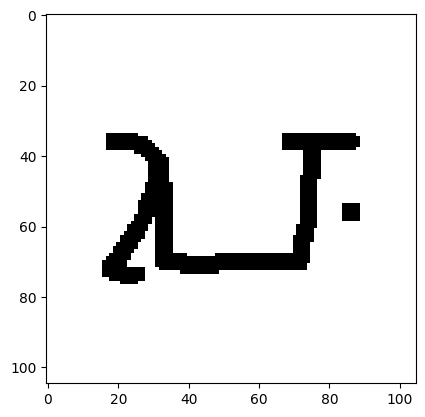

In [18]:
plt.imshow(image.squeeze(), cmap="gray")

In [21]:
all_targets = np.array([train_dataset[i][1] for i in range(len(train_dataset))])
all_labels = np.array(list(set(all_targets)))

In [23]:
print(all_targets)
print(all_labels, len(all_labels))

[  0   0   0 ... 963 963 963]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 

In [36]:
def sample_batch(batch_size):
    # 选取二分之一个batch的labels作为正样本，这样就完成了正样本的构造。
    positive_labels = np.random.choice(all_labels, batch_size // 2)
    
    # 针对这些labels，每个选取两张相同类别的图片
    batch = []
    for label in positive_labels:
        labels_indexes = np.argwhere(all_targets == label)
        pair = np.random.choice(labels_indexes.flatten(), 2)
        batch.append((pair[0], pair[1], 1))
        
    # 选取负样本
    negative_labels = np.random.choice(all_labels, batch_size)
    for sample1, sample2 in negative_labels.reshape(-1, 2):
        sample1 = np.random.choice(np.argwhere(all_targets == sample1).flatten(), 1)
        sample2 = np.random.choice(np.argwhere(all_targets == sample2).flatten(), 1)
        batch.append((sample1.item(), sample2.item(), 0)) # 图片类别不相同，所以target为0
        
    random.shuffle(batch)
    sample1_list = []
    sample2_list = []
    target_list = []
    for sample1, sample2, target in batch:
        sample1_list.append(train_dataset.__getitem__(sample1)[0])
        sample2_list.append(train_dataset.__getitem__(sample2)[0])
        target_list.append(target)
    sample1 = torch.stack(sample1_list)
    sample2 = torch.stack(sample2_list)
    targets = torch.LongTensor(target_list)
    return sample1, sample2, targets

In [38]:
sample1, sample2, targets = sample_batch(16)
print("sample1:", sample1.size())
print("sample2:", sample1.size())
print("targets:", targets)

sample1: torch.Size([16, 1, 105, 105])
sample2: torch.Size([16, 1, 105, 105])
targets: tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0])


In [47]:
import pandas as pd
import os
from pathlib import Path
picture_root = r"D:\workspace\MYData\比赛\厨房\初赛试题\picture"
video_root = r"D:\workspace\MYData\比赛\厨房\初赛试题\video"

filename = []
result = []

ret = {"filename": [], "result": []}

for i in Path(picture_root).iterdir():
    ret["filename"].append(i.name)
for i in Path(video_root).iterdir():
    ret["result"].append(i.name)

ret["result"] = [str(0) for _ in range(len(ret["filename"]))]

ret = pd.DataFrame(ret)
ret
ret.to_csv("./test.cvs", index=False)

,filename,result
0,ele_005807665b7ad9d176708074321222b3.jpg,0
1,ele_005898faf5cb419d117f531022c2172d.jpg,0
2,ele_011c08b56fbf12c9215760cad4351c19.jpg,0
3,ele_012e8ab7c72d00d9eb345c8b726404da.jpg,0
4,ele_01698053d610e12ecacee34e96266d4e.jpg,0
...,...,...
1722,ele_ff632dbcd356502cab861ff8f2c9f1c2.jpg,0
1723,ele_ff731077f68f4eade63616ce2462fcf0.jpg,0
1724,ele_ff9cae74ab500d31092b75f914ea0d48.jpg,0
1725,ele_ffa5294f6831494f9a01336ad2c54f74.jpg,0


In [54]:
import yaml
with open("test.yaml", 'r') as fr:
    infos = yaml.safe_load(fr)
print(infos)

{'description': 'This is a multiline\nstring in YAML.\nIt preserves line breaks\nand allows for easy formatting.'}


In [1]:
import cv2
import os
save_root = r"D:\workspace\data\bolt"
video = r"D:\Desktop\bf0abcb27e4c86c534e0f1eb6450bc14.mp4"

# 视频文件路径
video_path = r"D:\Desktop\bf0abcb27e4c86c534e0f1eb6450bc14.mp4"

# 打开视频文件
cap = cv2.VideoCapture(video_path)

# 检查视频是否成功打开
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# 逐帧读取视频
frame_count = 0
while True:
    # 读取一帧
    ret, frame = cap.read()

    # 检查是否成功读取帧
    if not ret:
        break

    # 生成输出文件名，可以根据需要修改命名规则
    output_filename = f'bolt_{frame_count:04d}.png'
    output_path = os.path.join(save_root, output_filename)

    # 保存当前帧为图像文件
    cv2.imwrite(output_path, frame)

    frame_count += 1

# 释放资源
cap.release()

print(f"{frame_count} frames extracted and saved as images.")

KeyboardInterrupt: 

In [ ]:
from pathlib import Path
raw_root = r"D:\workspace\data\bolt"
jsons = Path(raw_root).glob("*.json")

In [13]:
import random
def gen_txt():
    names = []
    for i in os.listdir(r"D:\workspace\data\bolt\Annotations"):
        names.append(i[:-5])
    
    random.shuffle(names)
    train_ratio = 0.8
    train_names = names[:int(len(names) * train_ratio)]
    test_names = names[int(len(names) * train_ratio):]

    print(len(train_names), len(test_names))

    with open(r"D:\workspace\data\bolt\ImageSets\Main\trainval.txt", 'w') as fw:
        for name in train_names:
            fw.write(name + "\n")

    with open(r"D:\workspace\data\bolt\ImageSets\Main\test.txt", 'w') as fw:
        for name in test_names:
            fw.write(name + "\n")

gen_txt()

16 4


In [4]:
import json
import cv2
import os
from lxml import etree
from pathlib import Path


def labelme2voc(img_path, out_dir):
    """
    img_path: 图片路径
    out_dir: xml保存的文件夹路径
    """
    
    # 创建VOC格式的xml文件
    annotations = etree.Element("annotation")

    # 添加文件名
    filename = etree.Element("filename")
    img_name = img_path.split(os.sep)[-1]
    filename.text = img_name
    annotations.append(filename)

    # 添加图像大小
    img = cv2.imread(img_path)
    h, w, c = img.shape
    size = etree.Element("size")
    width = etree.Element("width")
    height = etree.Element("height")
    depth = etree.Element("depth")
    width.text = str(w)
    height.text = str(h)
    depth.text = str(c)
    size.append(width)
    size.append(height)
    size.append(depth)
    annotations.append(size)

    # TODO: 这里需要注意下图片名后缀
    json_path = img_path.replace("JPEGImages", "raw").replace(".png", ".json")    
    with open(json_path, 'r', encoding="utf-8") as fr:
        infos = json.load(fr)
    for info in infos["shapes"]:
        obj = etree.Element("object")
        name = etree.Element("name")
        pose = etree.Element("pose")
        truncated = etree.Element("truncated")
        difficult = etree.Element("difficult")

        name.text = info["label"]
        pose.text = "Unspecified"
        truncated.text = str(1)
        difficult.text = str(0)
        obj.append(name)
        obj.append(pose)
        obj.append(truncated)
        obj.append(difficult)

        bndbox = etree.Element("bndbox")
        xmin = etree.Element("xmin")
        ymin = etree.Element("ymin")
        xmax = etree.Element("xmax")
        ymax = etree.Element("ymax")
        pts = info["points"]
        xmin.text, ymin.text = str(int(pts[0][0])), str(int(pts[0][1]))
        xmax.text, ymax.text = str(int(pts[1][0])), str(int(pts[1][1]))
        bndbox.append(xmin)
        bndbox.append(ymin)
        bndbox.append(xmax)
        bndbox.append(ymax)
        obj.append(bndbox)

        annotations.append(obj)
    
    xml_str = etree.tostring(annotations, pretty_print=True)
    xml_path = os.path.join(out_dir, img_name[:-4] + ".xml")
    with open(xml_path, "wb") as fw:
        fw.write(xml_str)


save_root = r"D:\workspace\data\bolt\Annotations"
json_root = Path(r"D:\workspace\data\bolt\raw").glob("*.json")
for i in json_root:
    print(str(i)[:-5] + ".png")
    labelme2voc(str(i)[:-5] + ".png", save_root)

D:\workspace\data\bolt\raw\bolt_0000.png
D:\workspace\data\bolt\raw\bolt_0001.png
D:\workspace\data\bolt\raw\bolt_0002.png
D:\workspace\data\bolt\raw\bolt_0003.png
D:\workspace\data\bolt\raw\bolt_0004.png
D:\workspace\data\bolt\raw\bolt_0005.png
D:\workspace\data\bolt\raw\bolt_0006.png
D:\workspace\data\bolt\raw\bolt_0007.png
D:\workspace\data\bolt\raw\bolt_0008.png
D:\workspace\data\bolt\raw\bolt_0009.png
D:\workspace\data\bolt\raw\bolt_0010.png
D:\workspace\data\bolt\raw\bolt_0011.png
D:\workspace\data\bolt\raw\bolt_0012.png
D:\workspace\data\bolt\raw\bolt_0013.png
D:\workspace\data\bolt\raw\bolt_0014.png
D:\workspace\data\bolt\raw\bolt_0015.png
D:\workspace\data\bolt\raw\bolt_0016.png
D:\workspace\data\bolt\raw\bolt_0017.png
D:\workspace\data\bolt\raw\bolt_0018.png
D:\workspace\data\bolt\raw\bolt_0019.png


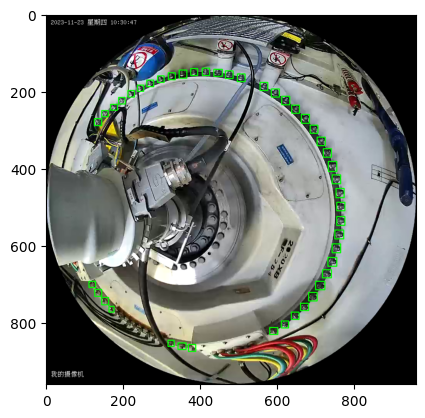

In [32]:
# 验证xml文件里的标注是否可以正确对应在图上
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt

def show_xml(xml_path, img_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    img = cv2.imread(img_path)
    for obj in root.findall("object"):
        name = obj.find("name").text
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    plt.imshow(img[:, :, ::-1])

xml_path = r"D:\workspace\data\bolt\Annotations\bolt_0001.xml"
img_path = r"D:\workspace\data\bolt\JPEGImages\bolt_0001.png"
show_xml(xml_path, img_path)